# DeeplabV3_plus

BackBone:       ResNet_50(pretrained = True)<br>
Paper:          Rethinking Atrous Convolution for Semantic Image Segmentation<br>
Research Paper: https://arxiv.org/abs/1706.05587<br>
Framework:      Pytorch<br>
Dataset:        2016ISIC dataset

In [ ]:
# to run the program on a specific GPU. AS my GPU 0 is not available
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import torch
device = torch.device('cuda')

In [ ]:
print(torch.cuda.current_device())

0


In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip"> training.zip
!unzip training.zip

In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip"> training_gd.zip
!unzip training_gd

In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip" > testing_data.zip
!unzip testing_data.zip

In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip" >testing_gt.zip
!unzip testing_gt.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/')

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

from torch.autograd import Variable
from __future__ import print_function
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import os
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
!pip install xlsxwriter 
import xlsxwriter

     |████████████████████████████████| 149 kB 4.1 MB/s 


# DATASET ISIC
All the Images in the dataset have different size so all images need to reshaped <br>
e.g. (x, y, 3)<br>

In [ ]:
#Loading Train data

class Isic_train_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Training_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Training_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Training_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Training_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
        img = img.resize((224, 224))
        mask = Image.open(mask_path)
        mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [ ]:
#Loading Test data

class Isic_test_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Test_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Test_GroundTruth"))))

    def __getitem__(self, idx):
#         pdb.set_trace()
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Test_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Test_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
        img = img.resize((224, 224))
        mask = Image.open(mask_path)
        mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            
        img_name = self.imgs[idx]
        return img, mask, img_name

    def __len__(self):
        return len(self.imgs)

In [ ]:
def my_segmentation_transforms(image):
    angle = 25
    image = TF.rotate(image, angle)
    return image

def scale_image(image):
#     scale = 1.2
    image = TF.affine(img=image, angle=0, translate=(0, 0), scale=1.3, shear=0)
    return image

transform1 = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])#transforms.Resize((224,224)),
transform2 = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(1), transforms.ToTensor()])
transform3 = transforms.Compose([transforms.Resize((224,224)), my_segmentation_transforms, transforms.ToTensor()])
transform4 = transforms.Compose([transforms.Resize((224,224)), scale_image, transforms.ToTensor()])

train_dataset     = Isic_train_Dataset('/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/one_result/', transforms=transform1)
horizontalflipped = Isic_train_Dataset('/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/one_result/', transforms=transform2)
rotated_image     = Isic_train_Dataset('/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/one_result/', transforms=transform3)
scaled_image      = Isic_train_Dataset('/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/one_result/', transforms=transform4)
# data Augmentation

increased_dataset = torch.utils.data.ConcatDataset([train_dataset, horizontalflipped, rotated_image, scaled_image])
lengths = [int(len(increased_dataset)*0.9), int(len(increased_dataset)*0.1)]
train_set, val_set = torch.utils.data.dataset.random_split(increased_dataset, lengths)

test_dataset = Isic_test_Dataset('/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/one_result/', transforms=transform1)

In [ ]:
# hyper-parameters
batch_size = 8

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# lengths of dataset
print('Length of original train data : ', len(train_dataset))
print('Length of Training data       : ', len(train_set))
print('Length of validation data     : ', len(val_set))
print('Length of Testing data        : ', len(test_dataset))

Length of original train data :  900
Length of Training data       :  3240
Length of validation data     :  360
Length of Testing data        :  379


# visualizing Data

    1.Visualizing Train Data

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])


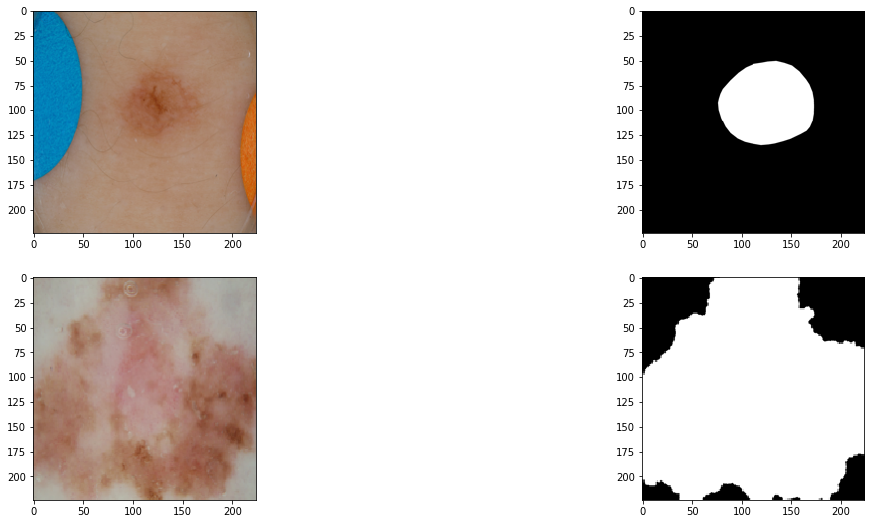

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
plt.imshow(images[0].permute(1, 2, 0))
plt.subplot(2,2,2)
plt.imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
plt.subplot(2,2,3)
plt.imshow(images[1].permute(1, 2, 0))
plt.subplot(2,2,4)
plt.imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# f, axarr = plt.subplots(2,2)
# axarr[0,0].imshow(images[0].permute(1, 2, 0)  )
# axarr[0,1].imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[1,0].imshow(images[1].permute(1, 2, 0)  )
# axarr[1,1].imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[2,0].imshow(images[2].permute(1, 2, 0)  )
# axarr[2,1].imshow(labels[2].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[3,0].imshow(images[3].permute(1, 2, 0)  )
# axarr[3,1].imshow(labels[3].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')

# Model
DeepLabv3 model expects the feature extracting architecture(Backbone) to be ResNet50 or ResNet101. <br>
![dc](https://miro.medium.com/max/1000/1*2mYfKnsX1IqCCSItxpXSGA.png)
<br>


In [ ]:
# i need to return the x after the first layer (Output_stride=4).
class ResNet_101 (nn.Module):
    def __init__(self, in_channels = 3, conv1_out = 64):
        super(ResNet_101,self).__init__()
    
        self.resnet_101 = models.resnet101(pretrained = True)
    
        self.relu = nn.ReLU(inplace=True)
  
    def forward(self,x):
#         print('Input_shape:', x.shape)
        x = self.relu(self.resnet_101.bn1(self.resnet_101.conv1(x)))
#         print('conv1_shape:', x.shape)
        x = self.resnet_101.maxpool(x)
        low_level_feature = self.resnet_101.layer1(x)
#         print('layer1_shape:', x.shape)
        x = self.resnet_101.layer2(low_level_feature)
#         print('layer2_shape:', x.shape)
        x = self.resnet_101.layer3(x)
#         print('layer3_shape:', x.shape)
#         x = self.resnet_50.layer4(x)
#         x = self.resnet_50.avgpool(x)

        return low_level_feature, x

In [ ]:
# noise = torch.randn(2, 3, 224, 224)
# m = ResNet_101()
# # print(m)
# low_level_feature, out = m(noise)
# print(low_level_feature.shape)
# print(out.shape)

In [ ]:
class ASSP(nn.Module):
  def __init__(self,in_channels,out_channels = 256):
    super(ASSP,self).__init__()
    
    
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 6,
                          dilation = 6,
                          bias=False)
    
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.conv3 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 12,
                          dilation = 12,
                          bias=False)
    
    self.bn3 = nn.BatchNorm2d(out_channels)
    
    self.conv4 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 18,
                          dilation = 18,
                          bias=False)
    
    self.bn4 = nn.BatchNorm2d(out_channels)
    
    self.conv5 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn5 = nn.BatchNorm2d(out_channels)
    
    self.convf = nn.Conv2d(in_channels = out_channels * 5, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bnf = nn.BatchNorm2d(out_channels)
    
    self.adapool = nn.AdaptiveAvgPool2d(1)  
   
  
  def forward(self,x):
#     print('Input_shape:',x.shape)
    x1 = self.conv1(x)
    x1 = self.bn1(x1)
    x1 = self.relu(x1)
#     print('x1_shape:',x1.shape)
    
    x2 = self.conv2(x)
    x2 = self.bn2(x2)
    x2 = self.relu(x2)
#     print('x2_shape:',x2.shape)
    
    x3 = self.conv3(x)
    x3 = self.bn3(x3)
    x3 = self.relu(x3)
#     print('x3_shape:',x3.shape)
    
    x4 = self.conv4(x)
    x4 = self.bn4(x4)
    x4 = self.relu(x4)
#     print('x4_shape:',x4.shape)
    
    x5 = self.adapool(x)
    x5 = self.conv5(x5)
    x5 = self.bn5(x5)
    x5 = self.relu(x5)
#     print('x5_shape:',x5.shape)
    x5 = F.interpolate(x5, size = tuple(x4.shape[-2:]), mode='bilinear')
#     print('x5_reshaped:',x1.shape)
#     print (x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    x = torch.cat((x1,x2,x3,x4,x5), dim = 1) #channels first
#     print('concat_shape:',x.shape)
    x = self.convf(x)
    x = self.bnf(x)
    x = self.relu(x)
    
    return x

In [ ]:
# noise = torch.randn(2, 1024, 32, 32, device='cpu')
# m = ASSP(in_channels=1024).to('cpu')
# # print(m)
# out = m(noise)
# out.shape

In [ ]:
class DeepLabv3plus(nn.Module):
  
  def __init__(self, nc):
    
    super(DeepLabv3plus, self).__init__()
    
    self.nc = nc
    
    self.resnet = ResNet_101()
    
    self.assp = ASSP(in_channels = 1024)
    
    self.conv = nn.Conv2d(in_channels = 256, out_channels = self.nc,
                          kernel_size = 1, stride=1, padding=0)    
    self.conv1 = nn.Conv2d(in_channels = 256, out_channels = 48, kernel_size = 1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(48)
    self.relu = nn.ReLU(inplace=True)
    
    self.activation = nn.Sigmoid()
    self.upsampleby4 = nn.UpsamplingBilinear2d(scale_factor=4)
#     self.output = nn.Sequential(
    self.conv2 = nn.Conv2d(in_channels=48+256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(256)
#     nn.ReLU(inplace=True)
    self.conv3 = nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(256)
#     nn.ReLU(inplace=True)
#     nn.Dropout(0.1)
    self. conv4 = nn.Conv2d(in_channels = 256, out_channels = self.nc, kernel_size = 1, stride=1, padding=0) 
#         )
    '''
    It is found that 48 channels of 1×1 convolution used to reduce the channels 
    of low-level feature map has the best performance.
    '''
        
  def forward(self,x):
    _, _, h, w = x.shape
#     import pdb; pdb.set_trace()
    low_level_feature, x = self.resnet(x)
    x = self.assp(x)
    x = self.upsampleby4(x)
    low_level_feature = self.conv1(low_level_feature)
    low_level_feature = self.relu(self.bn1(low_level_feature))
    x = torch.cat((x,low_level_feature), dim = 1)
#     x = self.output(x)
    x = self.conv2(x)
    x = self.relu(self.bn2(x))
    x = self.conv3(x)
    x = self.relu(self.bn3(x))
    x = self.conv4(x)
    x = self.activation(x)
    x = self.upsampleby4(x)
#     print('final_ouput_shape',x.shape)
    return x

In [ ]:
# noise = torch.randn(15, 3, 224, 224)
# m = DeepLabv3plus(1).to('cpu')
# out = m(noise)
# out.shape

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
       # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
learning_rate = 0.001
criterion = IoULoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9, weight_decay = 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
learning_rate = 0.001
from torchsummary import summary
# num_epochs = 5
model = DeepLabv3plus(1).to(device)
print(model)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9, weight_decay = 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5, last_epoch=-1, verbose=True)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

DeepLabv3plus(
  (resnet): ResNet_101(
    (resnet_101): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): Re

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='deeplabv3plus_resnet101_2016_wda.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('deeplabv3plus_resnet101_2016_wda.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
# batch_size = 8
n_epochs = 60
patience = 7
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[ 1/60] train_loss: 0.32574 valid_loss: 0.66320
Validation loss decreased (inf --> 0.663196).  Saving model ...
[ 2/60] train_loss: 0.19003 valid_loss: 0.32242
Validation loss decreased (0.663196 --> 0.322423).  Saving model ...
[ 3/60] train_loss: 0.16259 valid_loss: 0.19917
Validation loss decreased (0.322423 --> 0.199165).  Saving model ...
[ 4/60] train_loss: 0.14935 valid_loss: 0.48875
EarlyStopping counter: 1 out of 7
[ 5/60] train_loss: 0.14150 valid_loss: 0.45495
EarlyStopping counter: 2 out of 7
[ 6/60] train_loss: 0.13552 valid_loss: 0.44262
EarlyStopping counter: 3 out of 7
[ 7/60] train_loss: 0.12753 valid_loss: 0.14742
Validation loss decreased (0.199165 --> 0.147416).  Saving model ...
[ 8/60] train_loss: 0.12420 valid_loss: 0.14324
Validation loss decreased (0.147416 --> 0.143237).  Saving model ...
[ 9/60] train_loss: 0.12066 valid_loss: 0.12977
Validation loss decreased (0.143237 --> 0.129773).  Saving model ...
[10/60] train_loss: 0.11511 valid_loss: 0.14066
EarlyStop

# Save and Load Model

In [ ]:
# saving and loading Model
# PATH = 'DeeplabV3plus_Resnet50_ISIC2016_with_data_augmentation.pth'
# torch.save(model.state_dict(), PATH)

LOAD the model to evaluate.

In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

In [ ]:
# #to load weights
model = DeepLabv3plus(1).to(device)
PATH = 'deeplabv3plus_resnet101_2016_wda.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Evaluation Criteria

In [ ]:
#only of the lesion class not the mean. 
"""
Evaluation Criteria:
1. Accuracy
2. IntersectionoverUnion(Jaccard Index)
4. Dice coefficient(F1-score)
6. Specificity
7. Sensitivity
"""

def compute_tp_tn_fn_fp(pred, label):
    '''
    True positive - actual = 1, predicted = 1
    False positive - actual = 1, predicted = 0
    False negative - actual = 0, predicted = 1
    True negative - actual = 0, predicted = 0
    '''
    pred = pred.cpu().numpy().astype('int32')
    label = label.cpu().numpy().astype('int32')
    tp = np.sum((label == 1) & (pred == 1))
    tn = np.sum((label == 0) & (pred == 0))
    fn = np.sum((label == 1) & (pred == 0))
    fp = np.sum((label == 0) & (pred == 1))
    return tp, tn, fp, fn

#2 preferred
def compute_acc(tp, tn, fp, fn):
    return ((tp+tn)/(tp+tn+fp+fn))

def compute_iou(tp, tn, fp, fn):
    return (tp/(tp+fp+fn))

def compute_dc(tp, tn, fp, fn):
    return ((2*tp)/(2*tp + fp+fn))

def compute_meaniou(tp, tn, fp, fn):
    a = (tp/(tp+fp+fn))
    b = (tn/(tn+fn+fp))
    return ((a+b)/2)

def compute_meandc(tp, tn, fp, fn):
    a = ((2*tp)/(2*tp + fp + fn))
    b = ((2*tn)/(2*tn + fp + fn))
    return (a+b)/2

def compute_prec(tp, tn, fp, fn):
    return (tp/(tp + fp + 1e-5))

def compute_rec(tp, tn, fp, fn):
    return (tp/(tp + fn + 1e-5))

def compute_specificity(tp, tn, fp, fn):
    return (tn/(tn + fp))

def compute_sensitivity(tp, tn, fp, fn):
    return (tp/(tp + fn))


def evaluate_model(pred, label):
    tp, tn, fp, fn = compute_tp_tn_fn_fp(pred, label)
    
    acc = compute_acc(tp, tn, fp, fn)
    iou = compute_iou(tp, tn, fp, fn)
    dc  = compute_dc(tp, tn, fp, fn)
#     miou = compute_meaniou(tp, tn, fp, fn)
#     mdc  = compute_meandc(tp, tn, fp, fn)
#     prec = compute_prec(tp, tn, fp, fn)
#     rec = compute_rec(tp, tn, fp, fn)
    spec = compute_specificity(tp, tn, fp, fn)
    sen = compute_sensitivity(tp, tn, fp, fn)
    
    return acc, iou, dc, spec, sen #, miou, mdc, prec, rec


# Evaluating Model Performance

In [ ]:
#evaluate model

model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Training Data______________________________________________'''
    print('Training Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
    specificity = 0
    sensitivity = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    
    '''______________________________Evaluating Validation Data____________________________________________'''
    print('Validation Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    specificity = 0
    sensitivity = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    

Training Data


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Accuracy      : |   96.58  |
IoU           : |   88.91  |
DC            : |   94.10  |
Specificity   : |   96.95  |
Sensitivity   : |   95.21  |
-----------------------------------
Validation Data
Accuracy      : |   95.72  |
IoU           : |   87.49  |
DC            : |   93.31  |
Specificity   : |   96.16  |
Sensitivity   : |   94.40  |
-----------------------------------


Testing Data


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


--------------------------------------------------
Accuracy       :|   95.25  |
IoU            :|   82.57  |
DC             :|   89.62  |
Mean IoU       :|   94.72  |
Mean DC        :|   92.52  |
--------------------------------------------------
Visualizing Results


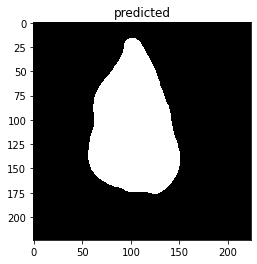

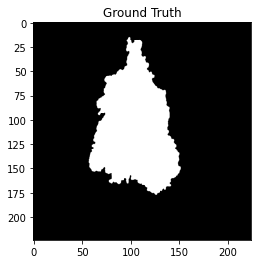

In [ ]:
#on Test Set

workbook = xlsxwriter.Workbook('deeplabv3plus_resnet101_2016_wda.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write(0, 0, "Image_name")
worksheet.write(0, 1, "Acc")
worksheet.write(0, 2, "IoU")
worksheet.write(0, 3, "DC")
worksheet.write(0, 4, "Spec")
worksheet.write(0, 5, "Sen")
# worksheet.write(0, 6, "Prec")
# worksheet.write(0, 7, "Rec")
row = 1
col = 0


model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Testing Data_______________________________________________'''
    print('Testing Data')
    
    acc_sum = []
    iou_sum = []
    dc_sum = []
    speci_sum = []
    sens_sum = []
#     miou_sum = []
#     mdc_sum = []
#     prec_sum = []
#     rec_sum = []
    
    for images, labels, image_name in test_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)

#         Saving the predicted Images
        pred_image = outputs.clone().detach()
        pred_image = pred_image.reshape(labels.shape[1], labels.shape[2], labels.shape[3])
        pred_image *= 255
        path = os.path.join("/content/drive/MyDrive/segmentation/DeepLabv3plus/deeplabv3plus_resnet101/BTPdeeplabv3plus_resnet101/"+image_name[0])
        save_image(pred_image, path)
#         img = Image.fromarray(pred_image)
#         img.save(os.path.join("predicted_image/"+image_name))
#         im1 = Image.save("predicted_image/", image_name) 
        
#         Computing evaluation metrics
        output_image = outputs[0]
        label_image = labels[0]
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        acc_sum.append(acc)
        iou_sum.append(iou)
        dc_sum.append(dc)
        speci_sum.append(spec)
        sens_sum.append(sen)
#         prec_sum.append(prec)
#         rec_sum.append(rec)
        
        #writing the data in excel sheet
        col = 0
        worksheet.write(row, col, image_name[0])
        temp = "{:.2f}".format(acc*100)
        worksheet.write(row, col+1, temp)
        temp = "{:.2f}".format(iou*100)
        worksheet.write(row, col+2, temp)
        temp = "{:.2f}".format(dc*100)
        worksheet.write(row, col+3, temp)
        temp = "{:.2f}".format(spec*100)
        worksheet.write(row, col+4, temp)
        temp = "{:.2f}".format(sen*100)
        worksheet.write(row, col+5, temp)
#         temp = "{:.2f}".format(prec*100)
#         worksheet.write(row, col+6, temp)
#         temp = "{:.2f}".format(rec*100)
#         worksheet.write(row, col+7, temp)
        row += 1
        
#         print('---------------------')
#         print(image_name)
#         print('Accuracy :{:.2f} '.format(acc*100))
#         print('IoU      :{:.2f} '.format(iou*100))
#         print('dc       :{:.2f} '.format(dc*100))
#         print('miou     :{:.2f} '.format(miou*100))
#         print('mdc      :{:.2f} '.format(mdc*100))
#         print('prec     :{:.2f} '.format(prec*100))
#         print('Rec      :{:.2f} '.format(rec*100))
#         print('---------------------')
    
    acc = sum(acc_sum)/len(acc_sum)
    iou = sum(iou_sum)/len(iou_sum)
    dc = sum(dc_sum)/len(dc_sum)
    spec = sum(speci_sum)/len(speci_sum)
    sen = sum(sens_sum)/len(sens_sum)
#     prec = sum(prec_sum)/len(prec_sum)
#     rec = sum(rec_sum)/len(rec_sum)
    
    print('--------------------------------------------------')
    print('Accuracy       :|   {:.2f}  |'.format(acc*100))
    print('IoU            :|   {:.2f}  |'.format(iou*100))
    print('DC             :|   {:.2f}  |'.format(dc*100))
    print('Mean IoU       :|   {:.2f}  |'.format(spec*100))
    print('Mean DC        :|   {:.2f}  |'.format(sen*100))
#     print('Precision      :|   {:.2f}  |'.format(prec*100))
#     print('Recall         :|   {:.2f}  |'.format(rec*100))
    print('--------------------------------------------------')
    print("Visualizing Results")
    output_image = output_image*255
    label_image = label_image*255
    plt.figure(1)
    plt.imshow(output_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("predicted")
    plt.figure(2)
    plt.imshow(label_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("Ground Truth")
    
workbook.close()        

# Loss Graphs

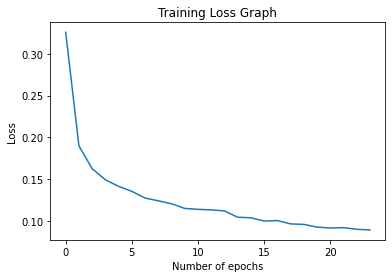

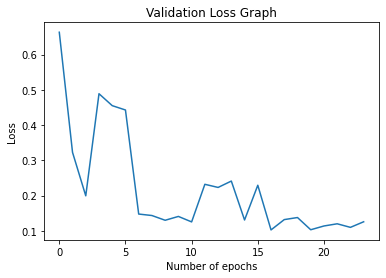

In [ ]:
# Loss Graph
plt.figure(1)
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss Graph')
plt.show()
plt.figure(2)
plt.plot(valid_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Validation Loss Graph')
plt.show()

In [ ]:
!zip -r myzip.zip Predicted_images_34

	zip warning: name not matched: Predicted_images_34

zip error: Nothing to do! (try: zip -r myzip.zip . -i Predicted_images_34)
